In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats
import plotly
import geopandas as gpd
from IPython.display import Markdown
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [84]:
#table1 = pd.read_csv(r'data\RV_O_010_L_OK_SK.csv', sep=';')
#table2 = pd.read_csv(r'data\RV_O_040_L_OK_SK.csv', sep=';')
#table3 = pd.read_csv(r'data\RV_O_047_L_OK_SK.csv', sep=';')
table4 = pd.read_csv(r'data\RV_O_067_L_OK_SK.csv', sep=';')
table4_pom = pd.read_csv(r'data\RV_O_067_R_KR_SK.csv', sep=';')

In [85]:
table4_pom.head(5)

,Kód štátu,Názov štátu,Kód oblasti,Kód kraja,Názov oblasti,Názov kraja,Súčasná ekonomická aktivita,Odvetvie ekonomickej činnosti​ (NACE - sekcie),Zamestnanie (ISCO - triedy),Vzdelanie,abs.
0,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,nezistené,1120
1,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 1. stupeň základnej školy,51
2,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 2. stupeň základnej školy,257
3,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,4
4,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,76


In [86]:
display(sum(table4_pom['abs.']))

2553891

In [87]:
education_types = table4.iloc[:, 5].unique()
vyssie_zoznam = [x for x in education_types if 'vysokoškolské' in x or "vyššie" in x]
stredne_zoznam = [x for x in education_types if "stredné" in x]
zakladne_zoznam = [x for x in education_types if "základné" in x]
neziskane_zoznam = ['bez školského vzdelania – osoby vo veku 15 rokov a viac'] 
ostatne_zoznam = [x for x in education_types if x not in vyssie_zoznam and x not in stredne_zoznam 
                  and x not in zakladne_zoznam and x not in neziskane_zoznam]

In [88]:
education_dict = {'vyššie': vyssie_zoznam,
                  'stredné': stredne_zoznam,
                  'základné': zakladne_zoznam,
                  'neziskané': neziskane_zoznam,
                  'ostatné': ostatne_zoznam}

main_education_dict = {value: key for key in education_dict.keys() for value in education_dict[key]}

In [89]:
table4_pom['Druh vzdelania'] = table4_pom['Vzdelanie'].map(main_education_dict)

In [90]:
education_series = table4_pom.groupby('Druh vzdelania')['abs.'].sum()

In [91]:
counts_df = pd.DataFrame({'Druh vzdelania': education_series.index,
                          'Počet ľudí': education_series.values})

In [92]:
counts_df

,Druh vzdelania,Počet ľudí
0,neziskané,1818
1,ostatné,69647
2,stredné,1409016
3,vyššie,953531
4,základné,119879


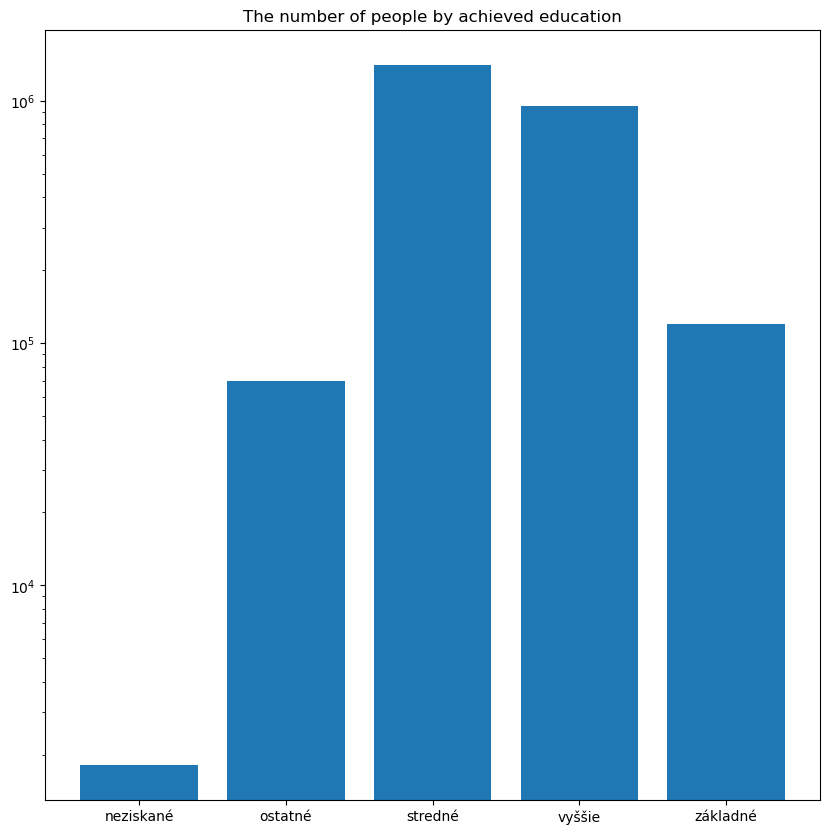

In [93]:
figure, axes = plt.subplots(figsize=(10, 10))
plt.bar(counts_df['Druh vzdelania'], counts_df['Počet ľudí'])
axes.semilogy()
plt.title('The number of people by achieved education')
plt.show()

Chcem preskúmať súvis medzi druhom zamestnania/pracovnou oblasťou (budú utriedené podľa ISCO klasifikácie, ktorá je zverejnená na ich webovej stránke (9 skupín)) a ziskaným vzdelaním. Sú to dve kategoriálne premenné, takže viem vyrobiť z toho "Parallel categories" graf.

1) Roztriediť zamestnania a dostať deväť skupín
2) Nakresliť graf

In [94]:
groups = {'Managers': ['Riadiaci pracovníci (manažéri)  administratívnych, podporných a obchodných  činností',
                'Riadiaci pracovníci (manažéri) vo výrobe a v špecializovaných službách',
                'Riadiaci pracovníci (manažéri) v hotelových, reštauračných, obchodných a v ostatných službách',
                'Zákonodarcovia, ústavní činitelia, vysokí štátni úradníci a najvyšší predstavitelia podnikov a organizácií'],
         'Professionals': ['Špecialisti v zdravotníctve', 'Špecialisti v oblasti práva, sociálnych vecí a kultúry',
                'Špecialisti administratívnych, podporných a obchodných činností', 
                'Špecialisti v oblasti vedy a techniky', 'Špecialisti v oblasti informačných a komunikačných technológií',
                'Učitelia a odborní pedagogickí pracovníci'],
         'Technicians and Associate Professionals': ['Technici a odborní pracovníci v oblasti vedy a techniky', 
                'Technici v oblasti informačných a komunikačných technológií', 
                'Odborní pracovníci administratívnych, podporných a obchodných činností', 'Odborní pracovníci v zdravotníctve',
                'Odborní pracovníci v oblasti práva, sociálnych vecí a kultúry a podobní pracovníci'],
         'Clerical Support Workers': ['Administratívni pracovníci na záznam číselných a skladových údajov',
                'Všeobecní administratívni pracovníci a zapisovatelia', 'Administratívni pracovníci v zákazníckych službách',
                'Ostatní pomocní administratívni pracovníci'],
         'Service and Sales Workers': ['Pracovníci v osobných službách', 'Predavači', 
                'Pracovníci v oblasti osobnej starostlivosti', 'Pracovníci verejnej ochrany a bezpečnostných služieb'],
         'Skilled Agricultural, Forestry and Fishery Workers': ['Kvalifikovaní pracovníci v poľnohospodárstve (trhovo orientovaní)',
                'Kvalifikovaní pracovníci v lesníctve, rybárstve a poľovníctve (trhovo orientovaní)',
                'Farmári, rybári, poľovníci a zberači úrody (samozásobovatelia)'],
         'Craft and Related Trades Workers': ['Kvalifikovaní stavební robotníci a remeselníci okrem elektrikárov',
                'Kvalifikovaní robotníci v hutníctve, strojárstve a podobní robotníci', 'Umeleckí a ruční remeselníci a tlačiari',
                'Elektrikári a elektronici', 'Spracovatelia a výrobcovia potravinárskych výrobkov, výrobkov z dreva a odevov'],
         'Plant and Machine Operators, and Assemblers': ['Operátori stacionárnych strojov a zariadení', 'Montážni robotníci',
                'Vodiči a obsluha pojazdných strojných zariadení'],
         'Elementary Occupations': ['Upratovači a pomocníci', 'Pomocní pracovníci v poľnohospodárstve, lesníctve a rybárstve',
                'Pomocní pracovníci v ťažbe, stavebníctve, výrobe a doprave', 'Pomocní pracovníci pri príprave jedla',
                'Pracovníci pri likvidácii odpadu a ostatní nekvalifikovaní pracovníci',
                'Pouliční predavači a pomocní pracovníci v podobných službách'],
         'Armed Forces Occupations': ['Dôstojníci ozbrojených síl', 'Poddôstojníci ozbrojených síl', 'Ostatné ozbrojené sily'],
         'Undefined': ['nezistené'],
         'Inapplicable': ['neaplikovateľné']}

occupation_groups = {value: key for key in groups.keys() for value in groups[key]}

In [95]:
economic_sectors_help = {'Undefined': ['nezistené'],
                     'Other activities': ['Ostatné činnosti'],
                     'Primary': ['Poľnohospodárstvo, lesníctvo a rybolov', 'Ťažba a dobývanie'],
                     'Secondary': ['Stavebníctvo', 'Priemyselná výroba'],
                     'Tertiary': ['Veľkoobchod a maloobchod; oprava motorových vozidiel a motocyklov',
                            'Doprava a skladovanie', 'Ubytovacie a stravovacie služby', 'Informácie a komunikácia',
                            'Činnosti v oblasti nehnuteľností', 'Odborné, vedecké a technické činnosti',
                            'Administratívne a podporné služby', 'Vzdelávanie', 'Umenie, zábava a rekreácia',
                            'Činnosti extrateritoriálnych organizácií a združení', 'Zdravotníctvo a sociálna pomoc',
                            'Dodávka elektriny, plynu, pary a studeného vzduchu', 'Finančné a poisťovacie činnosti',
                            'Dodávka vody; čistenie a odvod odpadových vôd, odpady a služby odstraňovania odpadov',
                            'Verejná správa a obrana; povinné sociálne zabezpečenie',
                            'Činnosti domácností ako zamestnávateľov; nediferencované činnosti v domácnostiach produkujúce tovary a služby na vlastné použitie']}

economic_sectors = {value: key for key in economic_sectors_help.keys() for value in economic_sectors_help[key]}

In [96]:
table4_pom['Druh zamestnania (ISCO - triedy)'] = table4_pom['Zamestnanie (ISCO - triedy)'].map(occupation_groups)
table4_pom['Ekonomický sektor (NACE - sekcie)'] = table4_pom['Odvetvie ekonomickej činnosti​ (NACE - sekcie)'].map(economic_sectors)

In [97]:
table4_pom.head(5)

,Kód štátu,Názov štátu,Kód oblasti,Kód kraja,Názov oblasti,Názov kraja,Súčasná ekonomická aktivita,Odvetvie ekonomickej činnosti​ (NACE - sekcie),Zamestnanie (ISCO - triedy),Vzdelanie,abs.,Druh vzdelania,Druh zamestnania (ISCO - triedy),Ekonomický sektor (NACE - sekcie)
0,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,nezistené,1120,ostatné,Undefined,Undefined
1,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 1. stupeň základnej školy,51,základné,Undefined,Undefined
2,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 2. stupeň základnej školy,257,základné,Undefined,Undefined
3,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,4,stredné,Undefined,Undefined
4,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,76,stredné,Undefined,Undefined


In [98]:
help_for_par1 = table4_pom.groupby(['Druh vzdelania', 'Druh zamestnania (ISCO - triedy)'])['abs.'].sum()

fig = go.Figure(go.Parcats(
    dimensions=[{'label': 'Vzdelanie',
         'values': [i[0] for i in help_for_par1.index.values]},
        {'label': 'Zamestnanie',
         'values': [i[1] for i in help_for_par1.index.values]}],
    
    counts=help_for_par1.values
))

fig.update_layout(height=600, width=800)

fig.show()

In [99]:
help_for_par2 = table4_pom.groupby(['Názov kraja','Druh vzdelania'])['abs.'].sum()

fig = go.Figure(go.Parcats(
    dimensions=[{'label': 'Vzdelanie',
         'values': [i[0] for i in help_for_par2.index.values]},
        {'label': 'Zamestnanie',
         'values': [i[1] for i in help_for_par2.index.values]}],
    
    counts=help_for_par2.values
))

fig.update_layout(height=600, width=800)

fig.show()

In [100]:
display(table4_pom.groupby('Ekonomický sektor (NACE - sekcie)')['abs.'].sum())

Ekonomický sektor (NACE - sekcie)
Other activities      49446
Primary               64378
Secondary            620614
Tertiary            1427411
Undefined            392042
Name: abs., dtype: int64

In [101]:
d = table4_pom.groupby('Ekonomický sektor (NACE - sekcie)')['abs.'].sum()

In [102]:
table4_pom['Súčet vnútri sektora'] = table4_pom['Ekonomický sektor (NACE - sekcie)'].map(d)

In [103]:
grouped_table = table4_pom.groupby(['Súčet vnútri sektora', 'Druh vzdelania'])['abs.'].sum()

def map_func(index1, index2):
    return grouped_table[(index1, index2)]

In [104]:
table4_pom['Súčet pre vzdelanie'] = table4_pom.apply(lambda x: map_func(x['Súčet vnútri sektora'], x['Druh vzdelania']), axis=1)
table4_pom['Percentage'] = table4_pom['Súčet pre vzdelanie'] * 100 / table4_pom['Súčet vnútri sektora']

table4_pom.head(5)

,Kód štátu,Názov štátu,Kód oblasti,Kód kraja,Názov oblasti,Názov kraja,Súčasná ekonomická aktivita,Odvetvie ekonomickej činnosti​ (NACE - sekcie),Zamestnanie (ISCO - triedy),Vzdelanie,abs.,Druh vzdelania,Druh zamestnania (ISCO - triedy),Ekonomický sektor (NACE - sekcie),Súčet vnútri sektora,Súčet pre vzdelanie,Percentage
0,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,nezistené,1120,ostatné,Undefined,Undefined,392042,11086,2.827758
1,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 1. stupeň základnej školy,51,základné,Undefined,Undefined,392042,24661,6.290397
2,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,základné vzdelanie - 2. stupeň základnej školy,257,základné,Undefined,Undefined,392042,24661,6.290397
3,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,4,stredné,Undefined,Undefined,392042,202690,51.701093
4,SK0,Slovenská republika,SK01,SK010,Bratislavský kraj,Bratislavský kraj,pracujúci (okrem dôchodcov),nezistené,nezistené,stredné odborné (učňovské) vzdelanie bez matur...,76,stredné,Undefined,Undefined,392042,202690,51.701093


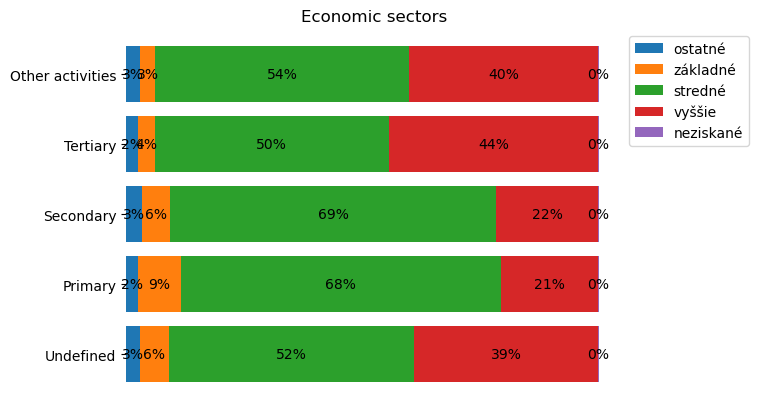

In [105]:
tmp_sectors = table4_pom['Ekonomický sektor (NACE - sekcie)'].unique()
tmp_education = table4_pom['Druh vzdelania'].unique()

starts = pd.Series([0] * tmp_sectors.shape[0])

figure, axes = plt.subplots()

# iterate through income groups
for group in tmp_education:  
    # select data for this income group from both regions
    tmp_data = table4_pom.query("`Druh vzdelania` == @group").drop_duplicates('Súčet pre vzdelanie')
    # plot
    rectangles = axes.barh(y=tmp_data['Ekonomický sektor (NACE - sekcie)'], width=tmp_data['Percentage'], left=starts, label=group)
    # add labels
    axes.bar_label(rectangles, label_type='center', fmt="%.0f%%")
    # move starts by the size of each rectangle
    starts += tmp_data['Percentage'].reset_index(drop=True) 

axes.set_title('Economic sectors')
axes.legend(bbox_to_anchor=(1, 1), loc=2)
# hide plot frame and x-axis ticks
axes.xaxis.set_visible(False)
axes.set_frame_on(False)
pass

In [106]:
table_for_pie = table4_pom.drop_duplicates(['Druh vzdelania', 'Ekonomický sektor (NACE - sekcie)', 'Súčet vnútri sektora'])

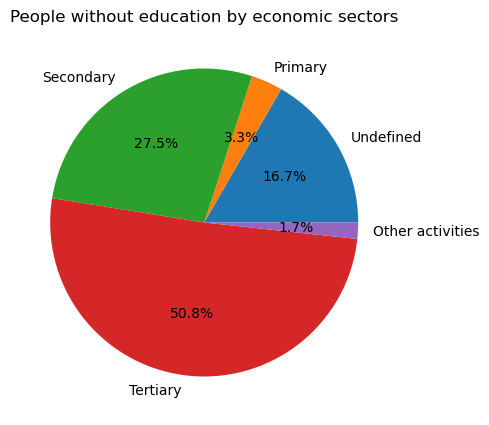

In [107]:
figure, axes = plt.subplots(figsize=(8,5))
axes.pie(x=table_for_pie.query('`Druh vzdelania` == "neziskané"')['Súčet pre vzdelanie'], labels=table_for_pie.query('`Druh vzdelania` == "neziskané"')['Ekonomický sektor (NACE - sekcie)'], autopct="%.1f%%")
axes.set_title('People without education by economic sectors')
pass

Text(0.5, 1.0, 'People with higher education by economic sectors')

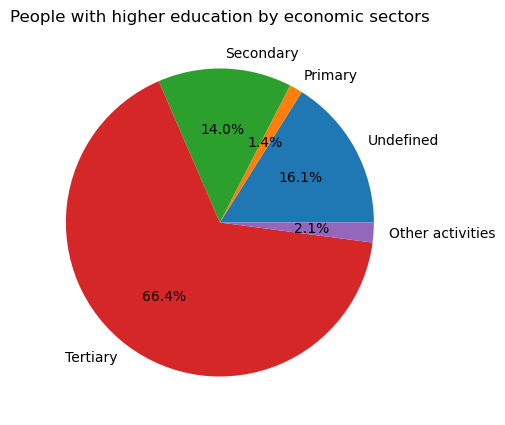

In [108]:
figure, axes = plt.subplots(figsize=(8,5))
axes.pie(x=table_for_pie.query('`Druh vzdelania` == "vyššie"')['Súčet pre vzdelanie'], labels=table_for_pie.query('`Druh vzdelania` == "vyššie"')['Ekonomický sektor (NACE - sekcie)'], autopct="%.1f%%")
axes.set_title('People with higher education by economic sectors')

Text(0.5, 1.0, 'People with elementary education by economic sectors')

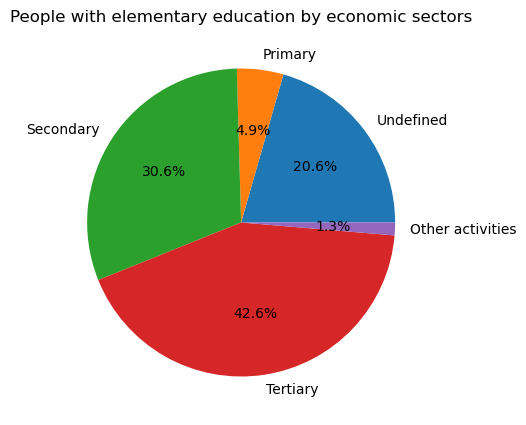

In [109]:
figure, axes = plt.subplots(figsize=(8,5))
axes.pie(x=table_for_pie.query('`Druh vzdelania` == "základné"')['Súčet pre vzdelanie'], labels=table_for_pie.query('`Druh vzdelania` == "základné"')['Ekonomický sektor (NACE - sekcie)'], autopct="%.1f%%")
axes.set_title('People with elementary education by economic sectors')

In [112]:
# create a list of all functions
#all_functions = list(functions['function'].unique())

# create a new dash application app
app = Dash(__name__)

# Create layout of items in application
#   one html <div> item containing text as small headwers (H4), 
#   items for individual inputs and a graph at the bottom
# Currently we have two inputs:
#   an input field for entering title text
#   checkboxes for selecting functions 
# These elements have identifiers which will be used later in the code
app.layout = html.Div([
    html.Div(children=[
        html.Label('Vzdelanie: '),
        dcc.Dropdown(['Bez školského vzdelania', 'Základné vzdelanie', 'Stredné vzdelamie',
                     'Vyššie vzdelanie', 'Ostatné vzdelanie'], 'Základné vzdelanie', id='education-type')]),
    
    html.Div(children=[
        html.Label('Zafarbit podla ekonomického sektoru: '),
        dcc.RadioItems(['áno', 'nie'], 'nie', id='color-choice')
    ]),
    
    dcc.Graph(id='graph-content')
])

# @app.callback is a function decorator applied to function update_figure below.
# It defines that this function will be called to update the graph when the user makes a change.
#    Input will be the value entered to the input field with id graph-title and 
#      the list of functions selected in dcc.Checklist object with id 'selected-functions'.
#    Output will be the graph created by the function update_figure below, which will be used
#      to update dcc.Graph object with id 'graph-content'
@app.callback(
    Output('graph-content', 'figure'),
    [
        Input('education-type', 'value'),
        Input('color-choice', 'value')
    ]
)
def update_figure(selected_education, color_c):
    """ Function for ploting functions listed in list selected_functions
    with plot title given in title"""
    education_dict = {'Bez školského vzdelania': 'neziskané',
                      'Základné vzdelanie': 'základné',
                      'Stredné vzdelamie': 'stredné',
                      'Vyššie vzdelanie': 'vyššie',
                      'Ostatné vzdelanie': 'ostatné'}
    education = education_dict.get(selected_education)
    
    # select a subset of functions table with just those functions in input list
    education_subset = table4_pom.query('`Druh vzdelania` == @education').groupby(['Druh zamestnania (ISCO - triedy)', 'Ekonomický sektor (NACE - sekcie)'])['abs.'].sum()
    
    if color_c == 'áno':
        color_c = [i[1] for i in education_subset.index.values]
    else:
        color_c = None
    
    # create a plotly line plot using the smaller table in functions_subset
    figure = px.histogram(education_subset, x=[i[0] for i in education_subset.index.values], y='abs.',
                          width=900, height=600, color=color_c)

    # add title to the plot
    figure.update_layout(title_text='Zamestnanie podla vzdelania')    

    return figure

# run the whole application
app.run_server(mode='inline')